Main database Link : 
https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/MyDrive/MALIS/project/data/ai4i2020.csv')
except:
    df = pd.read_csv('./data/ai4i2020.csv')

In [72]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [73]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [74]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000




```
# Ce texte est au format code
```

Let's first try to understand the data, and have a first look at the Tool Wear parameter. The tool wear is the number of consecutive minutes one tool has been used. When it goes down to 0 it means that the tool broke.

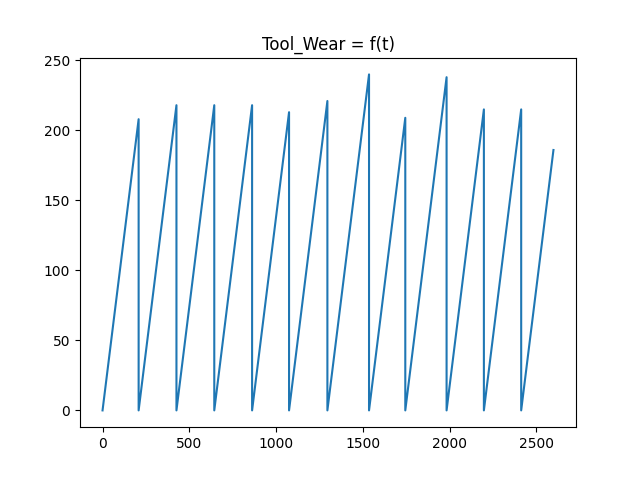

In [75]:
totalTime = [0]*10000
for i in range(1,10000):
  if df['Tool wear [min]'][i] == 0:
    totalTime[i] = totalTime[i-1]+df['Tool wear [min]'][i]
  else:
    totalTime[i] = totalTime[i-1] + df['Tool wear [min]'][i]-df['Tool wear [min]'][i-1]
#plt.plot(totalTime)
df['totalTime'] = totalTime

plt.figure()
plt.title("Tool_Wear = f(t)")
plt.plot([df['totalTime'][i] for i in range(1000)], df['Tool wear [min]'][:1000])

And if we take the problem in the other way around, we can compute and draw the number of days before the tool breaks:

In [76]:
y = []

UDI_breaks = []
for i in df.UDI:
  if df.TWF[i-1] == 1:
    UDI_breaks.append(i)
# print(UDI_breaks)
UDI_breaks_iterator = iter(UDI_breaks)
actual_break_UDI = next(UDI_breaks_iterator)

for i in range(3000):
  if i > actual_break_UDI:
    # print(actual_break_UDI)
    actual_break_UDI = next(UDI_breaks_iterator)
  y.append(df['Tool wear [min]'][actual_break_UDI-1] - df['Tool wear [min]'][i])
  
plt.plot(y)
plt.plot([0]*3000)

Let's have a closer look at our distribution of failure point. Let's compute the mean interval between two tool failures and the variance of it:

In [77]:
intervals_length = []
for i in df.UDI:
  if df.TWF[i-1] == 1:
    intervals_length.append(df['Tool wear [min]'][i-1])

plt.plot([i for i in range(len(intervals_length))], intervals_length)

intervals_length = np.array(intervals_length)
print("Tool wear failure interval distribution")
print("Mean:               {} min".format(np.mean(intervals_length)))
print("Variance:           {} min".format(np.var(intervals_length)))
print("Standard Deviation:  {} min".format(np.std(intervals_length)))


Tool wear failure interval distribution
Mean:               216.3695652173913 min
Variance:           146.97211720226844 min
Standard Deviation:  12.123205731252293 min


Let's create a dataset with cumulative data (First with the Torque and the Rpm only)

In [78]:
data = {
    'Torque':[0]*9999,
    'Rpm':[0]*9999,
    'ToolWear':[0]*9999,
    'Failure':[0]*9999
}
cumulative_df = pd.DataFrame(data)
lastChangePoint = 0
for i in range(9999):
  cumulative_df['ToolWear'][i] = df['Tool wear [min]'][i]
  if df['Tool wear [min]'][i] == 0:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])
  else:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) + cumulative_df['Torque'][i-1]
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) + cumulative_df['Rpm'][i-1]
  if df['TWF'][i]==1:
    cumulative_df['Failure'][i]=1
  else:
    cumulative_df['Failure'][i]=0

  

In [79]:
cumulative_df.head(80)

,Torque,Rpm,ToolWear,Failure
0,128,4653,0,0
1,220,7469,3,0
2,318,10465,5,0
3,397,13331,7,0
4,477,16147,9,0
...,...,...,...,...
75,8179,317700,204,0
76,8274,320622,206,0
77,8274,320622,208,1
78,103,2796,0,0


Let's split in a training and test dataset:

In [80]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure'], axis=1), cumulative_df[['Failure']], test_size=4000)
print(np.ravel(np.array(y_train)))

[0 1 0 ... 0 0 0]


Let's first try a Logistic regression on the cumulative torque and rpm to predict if there is a tool failure or not.

In [81]:
LR_model_1 = LogisticRegression(solver='liblinear', max_iter=2000)
LR_model_1.fit(X_train, np.ravel(np.array(y_train)));

In [82]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure'], axis=1), cumulative_df[['Failure']], test_size=4000)

LR_model_1.fit(X_train, np.ravel(np.array(y_train)));

def predict_and_test(LR_model,X,y):
  y_hat = LR_model.predict(X)
  y = np.array(y)
  corrects = 0
  corrects_0 = 0
  count_1 = 0
  count_0 = 0
  for i in range(len(y)):
    if (y[i] == 1):
      count_1 += 1
      if(y_hat[i] == y[i]):
        corrects+=1
    if (y[i]==0):
      count_0 += 1
      if (y_hat[i] == y[i]):
        corrects_0 += 1
  print(count_1)
  return (corrects/count_1,corrects_0/count_0)


accuracy_training = predict_and_test(LR_model_1,X_test,y_test)
print(accuracy_training)
print(np.sum(np.array(y_test))/len(y_test))

24
(0.0, 1.0)
0.006


We are not getting any results for now because there is way too many 0 compared to 1 in y_test. We should try to diminish the ratio 0/1 by only keeping the one just before the failure.

Let's add a column that compute the RUL to the dataframe in order to try the regression.

In [83]:
RUL = []

toolChanges = []
for i in range(1,10000):
  if df['Tool wear [min]'][i-1] == 0:
    toolChanges.append(i-2);
iterator = iter(toolChanges)
actual = next(iterator)

for i in range(9999):
  if i > actual:
    actual = next(iterator,9999)
  RUL.append(df['Tool wear [min]'][actual] - df['Tool wear [min]'][i])


cumulative_df['RUL']=RUL

Try a linear regression now:

In [84]:
from sklearn.linear_model import LinearRegression

In [85]:
X_train, X_test, y_train, y_test=train_test_split(cumulative_df.drop(['Failure','RUL'], axis=1), cumulative_df[['RUL']], test_size=4000)
X_train,X_test,y_train, y_test = np.array(X_train), np.array(X_test), np.ravel(np.array(y_train)),np.ravel(np.array(y_test))
reg = LinearRegression().fit(X_train,y_train)
y_hat = reg.predict(X_test)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)

[199 201 140 ...  62  54 121]


In [86]:
print(reg.score(X_train,y_train))

0.9644178384465477


Calculons la MSE:

In [87]:
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print(MSE)

147.1811973275704


What interests us is the low RULs so let's compute the MSEl for points with low RULs let's see the MSE for points with RUL <= 20

In [88]:
treshold = 40
sum = 0
count = 0
for i in range(len(y_test)):
  if (y_test[i]<=treshold):
    sum += (y_hat[i]-y_test[i])**2
  count += 1
MSEl = sum/count
print(MSEl)

55.54497525302515


We see that the MSE for points with low RULs is quite better.

Let's try to train the model on points with low RULs:

In [89]:
cumulative_onlyLowRul_df = cumulative_df.copy()
cumulative_onlyLowRul_df = cumulative_onlyLowRul_df[cumulative_onlyLowRul_df['RUL'] <= 40]

X_train, X_test, y_train, y_test=train_test_split(cumulative_onlyLowRul_df.drop(['Failure','RUL'], axis=1), cumulative_onlyLowRul_df[['RUL']], test_size=int(0.4*len(cumulative_onlyLowRul_df)))
X_train,X_test,y_train, y_test = np.array(X_train), np.array(X_test), np.ravel(np.array(y_train)),np.ravel(np.array(y_test))
regLow = LinearRegression().fit(X_train,y_train)
y_hat = regLow.predict(X_test)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])

MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print(MSE)

86.21837254445185


The results are worse with only low RULs on the training

Let's try with only the Torque*time:

In [90]:

X_train_df, X_test_df, y_train_df, y_test_df=train_test_split(cumulative_df.drop(['Failure','RUL'], axis=1), cumulative_df[['RUL']], test_size=4000)
print(X_train_df.dtypes)
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm'],axis=1)), np.array(X_test_df.drop(['Rpm'],axis=1))

X_train,X_test,y_train, y_test = np.array(X_train_df), np.array(X_test_df), np.ravel(np.array(y_train_df)),np.ravel(np.array(y_test_df))
reg = LinearRegression().fit(X_train,y_train)
y_hat = reg.predict(X_test)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for Torque, ToolWear and Rpm : " + str(MSE))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only Torque and ToolWear : " + str(MSE))

#Let's see if we only keep the tool Wear
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm','Torque'],axis=1)), np.array(X_test_df.drop(['Rpm','Torque'],axis=1))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)
abscissas = [i for i in range(100)]
plt.plot(abscissas,y_hat[:100])
plt.plot(abscissas,y_test[:100])
print(y_test)
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only ToolWear : " + str(MSE))

Torque      int64
Rpm         int64
ToolWear    int64
dtype: object
[110  19 165 ... 201  37 182]
MSE for Torque, ToolWear and Rpm : 123.17378481534074
[110  19 165 ... 201  37 182]
MSE for only Torque and ToolWear : 123.19771599078817
[110  19 165 ... 201  37 182]
MSE for only ToolWear : 124.4671516792959


Let's take consecutive datas:

In [91]:

X_train_df, X_test_df, y_train_df, y_test_df=cumulative_df[:6000].drop(['Failure','RUL'], axis=1),cumulative_df[6000:].drop(['Failure','RUL'], axis=1),cumulative_df[['RUL']][:6000],cumulative_df[['RUL']][6000:]
print(X_train_df.dtypes)
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm'],axis=1)), np.array(X_test_df.drop(['Rpm'],axis=1))

aff_len = 1000
abscissas = [i for i in range(aff_len)]
abscissas_shift = [i+10 for i in range(aff_len)]

plt.plot(abscissas_shift,y_test[:aff_len])

X_train,X_test,y_train, y_test = np.array(X_train_df), np.array(X_test_df), np.ravel(np.array(y_train_df)),np.ravel(np.array(y_test_df))
reg = LinearRegression().fit(X_train,y_train)
y_hat = reg.predict(X_test)
plt.plot(abscissas,y_hat[:aff_len])
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for Torque, ToolWear and Rpm : " + str(MSE))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)

plt.plot(abscissas,y_hat[:aff_len])
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only Torque and ToolWear : " + str(MSE))

#Let's see if we only keep the tool Wear
X_train_onlyTorque, X_test_onlyTorque = np.array(X_train_df.drop(['Rpm','Torque'],axis=1)), np.array(X_test_df.drop(['Rpm','Torque'],axis=1))

reg = LinearRegression().fit(X_train_onlyTorque,y_train)
y_hat = reg.predict(X_test_onlyTorque)
plt.plot(abscissas,y_hat[:aff_len])
MSE= 1/len(X_test)*np.sum((y_test-y_hat)**2)
print("MSE for only ToolWear : " + str(MSE))

Torque      int64
Rpm         int64
ToolWear    int64
dtype: object
MSE for Torque, ToolWear and Rpm : 184.3224012454779
MSE for only Torque and ToolWear : 184.64873049237025
MSE for only ToolWear : 184.77552562517306


In [92]:
change = cumulative_df[['ToolWear','Torque','Rpm']].iloc[toolChanges[1:]][cumulative_df['ToolWear']>200]
not_toolChanges = [i for i in range(9999)]
for i in toolChanges[1:]:
  del not_toolChanges[not_toolChanges.index(i)]
not_change = cumulative_df[['ToolWear','Torque','Rpm']].iloc[not_toolChanges][cumulative_df['ToolWear']>200]

In [93]:
plt.scatter([0 for i in range(len(change))],change['ToolWear'],c='#FF0000')
plt.scatter([0 for i in range(len(not_change))],not_change['ToolWear'],c='#00FF00')

In [94]:
plt.scatter([0 for i in range(len(change))],change['Torque'],c='#FF0000')
plt.scatter([0 for i in range(len(not_change))],not_change['Torque'],c='#00FF00')

In [95]:
plt.scatter([0 for i in range(len(change))],change['Rpm'],c='#FF0000')
plt.scatter([0 for i in range(len(not_change))],not_change['Rpm'],c='#00FF00')

In [96]:
plt.scatter(change['Torque'],change['ToolWear'],c='#FF0000')
plt.scatter(not_change['Torque'],not_change['ToolWear'],c='#00FF00')

In [97]:
plt.scatter(change['Rpm'],change['ToolWear'],c='#FF0000')
plt.scatter(not_change['Rpm'],not_change['ToolWear'],c='#00FF00')

In [98]:
plt.scatter(change['Rpm'],change['Torque'],c='#FF0000')
plt.scatter(not_change['Rpm'],not_change['Torque'],c='#00FF00')

Text(0.5, 0, 'ToolWear')

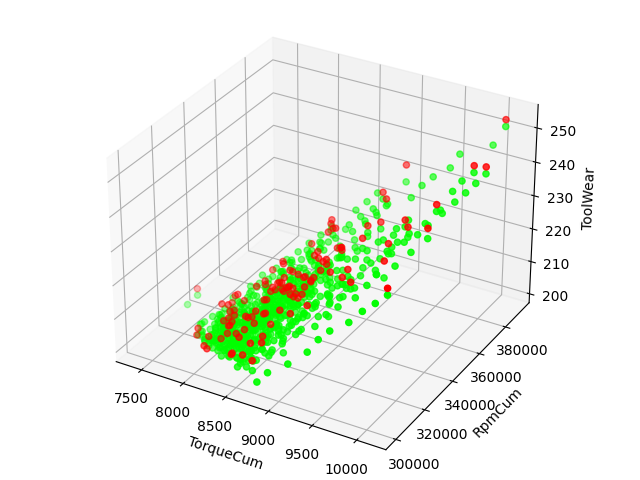

In [99]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(change['Torque'],change['Rpm'],change['ToolWear'],c='#FF0000')
ax.scatter3D(not_change['Torque'],not_change['Rpm'],not_change['ToolWear'],c='#00FF00')
ax.set_title("Tool change in function of RpmCum TorqueCum and ToolWear")
ax.set_xlabel('TorqueCum')
ax.set_ylabel('RpmCum')
ax.set_zlabel('ToolWear')


In [100]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

Let's try a SVM to exploit this linearly separability.
We will first focus on the low RULs point to see what we get:

In [101]:
data = {
    'Torque':[0]*9999,
    'Rpm':[0]*9999,
    'ToolWear':[0]*9999,
    'ToolChange':[0]*9999
}
cumulative_df = pd.DataFrame(data)
lastChangePoint = 0
for i in range(9999):
  cumulative_df['ToolWear'][i] = df['Tool wear [min]'][i]
  if df['Tool wear [min]'][i] == 0:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) / 10
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) / 1000
  else:
    cumulative_df['Torque'][i] = df['Torque [Nm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i]) / 10 + cumulative_df['Torque'][i-1]
    cumulative_df['Rpm'][i] = df['Rotational speed [rpm]'][i] * (df['totalTime'][i+1]-df['totalTime'][i])  / 1000 + cumulative_df['Rpm'][i-1] 
  if df['Tool wear [min]'][i+1]==0:
    cumulative_df['ToolChange'][i]=1
  else:
    cumulative_df['ToolChange'][i]=0


cumulative_df_onlyLowRul = cumulative_df[cumulative_df['ToolWear']>200]

In [102]:

nbLowRuls = len(cumulative_df_onlyLowRul)
print(nbLowRuls)
cumulative_df_onlyLowRul.describe()


762


,Torque,Rpm,ToolWear,ToolChange
count,762.000000,762.000000,762.000000,762.000000
mean,818.053806,287.524934,212.062992,0.150919
std,45.207316,14.001034,9.427709,0.358205
min,708.000000,260.000000,201.000000,0.000000
25%,788.000000,278.000000,205.000000,0.000000
50%,811.000000,285.000000,210.000000,0.000000
75%,840.000000,295.000000,217.000000,0.000000
max,970.000000,352.000000,253.000000,1.000000


In [103]:
lenTrainSet = round(nbLowRuls*0.6)
lenTestSet = nbLowRuls - lenTrainSet
X_trainSVM_df,X_testSVM_df,y_trainSVM_df,y_testSVM_df = cumulative_df_onlyLowRul[['Torque','Rpm','ToolWear']][:lenTrainSet],cumulative_df_onlyLowRul[['Torque','Rpm','ToolWear']][lenTrainSet:],cumulative_df_onlyLowRul[['ToolChange']][:lenTrainSet],cumulative_df_onlyLowRul[['ToolChange']][lenTrainSet:]
X_trainSVM,X_testSVM,y_trainSVM, y_testSVM = np.array(X_trainSVM_df), np.array(X_testSVM_df), np.ravel(np.array(y_trainSVM_df)),np.ravel(np.array(y_testSVM_df))
print(y_trainSVM)
X_testSVM_df.describe()

[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 1 0 0 0 0]


,Torque,Rpm,ToolWear
count,305.000000,305.000000,305.000000
mean,816.193443,285.062295,210.993443
std,46.401409,11.736949,8.511599
min,708.000000,261.000000,201.000000
25%,788.000000,277.000000,204.000000
50%,809.000000,284.000000,209.000000
75%,834.000000,291.000000,215.000000
max,970.000000,328.000000,246.000000


In [104]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.simplefilter("ignore")
from sklearn.exceptions import ConvergenceWarning

In [105]:
classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(solver='liblinear', max_iter=400),
    SVC(kernel="linear", C=2000),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(learning_rate_init=0.05, max_iter=3000, hidden_layer_sizes=(10), batch_size=60, learning_rate='constant',  activation='logistic', solver='sgd', tol=-10.),
    MLPClassifier(learning_rate_init=0.05, max_iter=4000, hidden_layer_sizes=(10, 10), batch_size=60, learning_rate='constant', activation='logistic', solver='sgd', tol=-10.)]

for clf in classifiers:
    print(clf.fit(X_trainSVM,y_trainSVM))
    score = clf.score(X_testSVM,y_testSVM)
    print("Score = " + str(score))

KNeighborsClassifier(n_neighbors=3)
Score = 0.8295081967213115
LogisticRegression(max_iter=400, solver='liblinear')
Score = 0.8360655737704918


In [ ]:
print(len(change), len(not_change), len(change)/len(not_change))

115 647 0.1777434312210201
